In [17]:
import pandas as pd
import numpy as np

# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

It uses bootstrap resampling (random sampling with replacement) to learn several models on random variations of the training set. 

At predict time, the predictions of each learner are aggregated to give the final predictions.

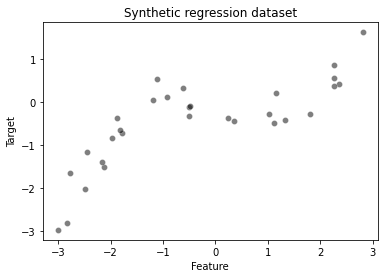

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

### Bootstrap 사용 전

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

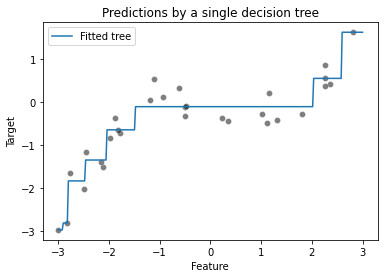

In [20]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test["Feature"], y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

### Bootstrap resampling

Bootstrapping is a resampling “with replacement” of the original dataset. It corresponds to sampling n out of n data points with replacement uniformly at random from the original dataset.

In [21]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

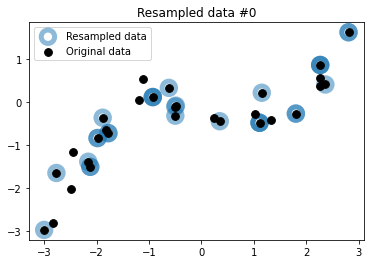

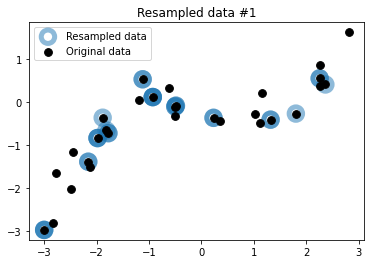

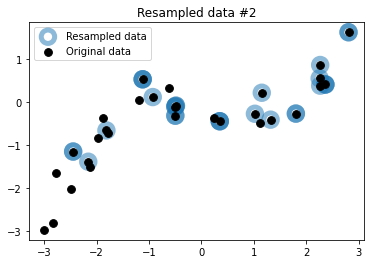

In [22]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train, target_train,
    )
    plt.figure()
    plt.scatter(data_bootstrap["Feature"], target_bootstrap,
                color="tab:blue", facecolors="none",
                alpha=0.5, label="Resampled data", s=180, linewidth=5)
    plt.scatter(data_train["Feature"], target_train,
                color="black", s=60,
                alpha=1, label="Original data")
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

* Some of the points are randomly resampled several times and appear as darker blue circles.

* bootstrap은 진짜 무작위로 뽑는듯 심지어 중복 되더라도 상관 없음


In [25]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge)

ratio_unique_sample = (np.unique(data_bootstrap_sample).size /
                       data_bootstrap_sample.size)
print(
    f"Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%")

Percentage of samples present in the original dataset: 63.2%


In [26]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train)
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

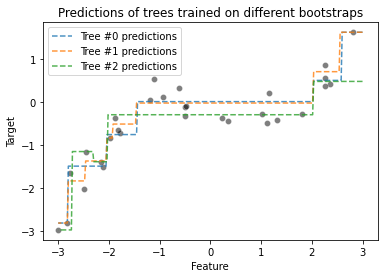

In [27]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

### Aggregating
the most straightforward way to combine those predictions is just to average them: for a given test data point, we feed the input feature values to each of the n trained models in the ensemble and as a result compute n predicted values for the target variable.

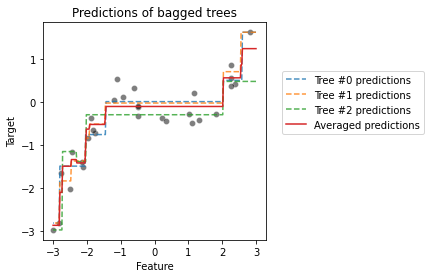

In [30]:
plt.figure(figsize=(4,4))
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")
    bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(data_test["Feature"], bag_predictions, label="Averaged predictions",
         linestyle="-")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predictions of bagged trees")


* The unbroken red line shows the averaged predictions, which would be the final predictions given by our ‘bag’ of decision tree regressors. 

* Note that the predictions of the ensemble is more stable because of the averaging operation. 

### Sklearn에서 Bagging

* Because we use 100 trees in the ensemble, the average prediction is indeed slightly smoother but very similar to our previous average plot.

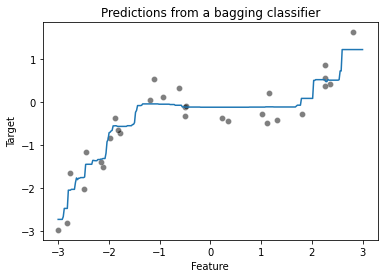

In [31]:
from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
_ = bagged_trees.fit(data_train, target_train)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")

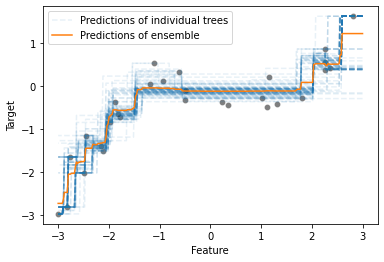

In [32]:
for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend()

### Pipeline과 Bagging 사용하기
* This pipeline first scales the data to the 0-1 range with MinMaxScaler.
* Note that we intentionally use a small value for the regularization parameter `alpha` as we expect the bagging ensemble to work well with slightly overfit base models.

In [35]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=4),Ridge(alpha=1e-10))

In [36]:
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

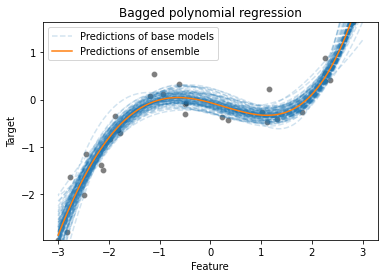

In [37]:
for i, regressor in enumerate(bagging.estimators_):
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    regressor_predictions = regressor.predict(data_test.to_numpy())
    base_model_line = plt.plot(
        data_test["Feature"], regressor_predictions, linestyle="--", alpha=0.2,
        label="Predictions of base models" if i == 0 else None,
        color="tab:blue"
    )

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
bagging_predictions = bagging.predict(data_test)
plt.plot(data_test["Feature"], bagging_predictions,
         color="tab:orange", label="Predictions of ensemble")
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")

* The predictions of this bagged polynomial regression model looks qualitatively better than the bagged trees. This is somewhat expected since the base model better reflects our knowledge of the true data generating process.